# MODELO FORECAST UNIVARIADO SERIES DE TIEMPO USDPEN


In [9]:
# 1. Configuración inicial y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import NBEATSModel, AutoARIMA, NHiTSModel, TiDEModel, TSMixerModel, Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mae, mape
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import optuna
import json
from typing import Optional
from datetime import datetime
import pickle
import os
from tqdm import tqdm

In [10]:
import logging

# Establece el nivel de logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [11]:
# Cargar datos
df = pd.read_csv('monthly_data.csv')
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)

df = df.dropna()
df.head(), df.tail()

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_13536\2008386010.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATES'] = pd.to_datetime(df['DATES'])


(              PEN
 DATES            
 1994-12-31  2.185
 1995-01-31  2.194
 1995-02-28  2.237
 1995-03-31  2.258
 1995-04-30  2.245,
                PEN
 DATES             
 2024-04-30  3.7664
 2024-05-31  3.7245
 2024-06-30  3.8425
 2024-07-31  3.7283
 2024-08-31  3.7493)

In [12]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [19]:

test_dates = test.time_index 
train_dates = train.time_index
#Last date of test_date
last_train_date = train_dates[-1]
first_test_date = test_dates[0]
# value of df[PEN] in last_train_date
last_train_value = df['PEN'][last_train_date]
last_train_value


3.2878

In [20]:
PEN_TEST = df.loc[test_dates, 'PEN']
PEN_TEST

DATES
2018-09-30    3.3040
2018-10-31    3.3715
2018-11-30    3.3830
2018-12-31    3.3685
2019-01-31    3.3275
               ...  
2024-04-30    3.7664
2024-05-31    3.7245
2024-06-30    3.8425
2024-07-31    3.7283
2024-08-31    3.7493
Name: PEN, Length: 72, dtype: float64

In [17]:
# Analisis de la serie train
df_train = train.pd_dataframe()



component,PEN
DATES,
1994-12-31,2.185
1995-01-31,2.194
1995-02-28,2.237
1995-03-31,2.258
1995-04-30,2.245


In [198]:
print(df_train.describe())

component         PEN
count      287.000000
mean         3.064202
std          0.364682
min          2.185000
25%          2.795750
50%          3.173000
75%          3.373250
max          3.632000


c:\Users\Carlos Palma\.conda\envs\tesis\lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\Carlos Palma\.conda\envs\tesis\lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\Carlos Palma\.conda\envs\tesis\lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


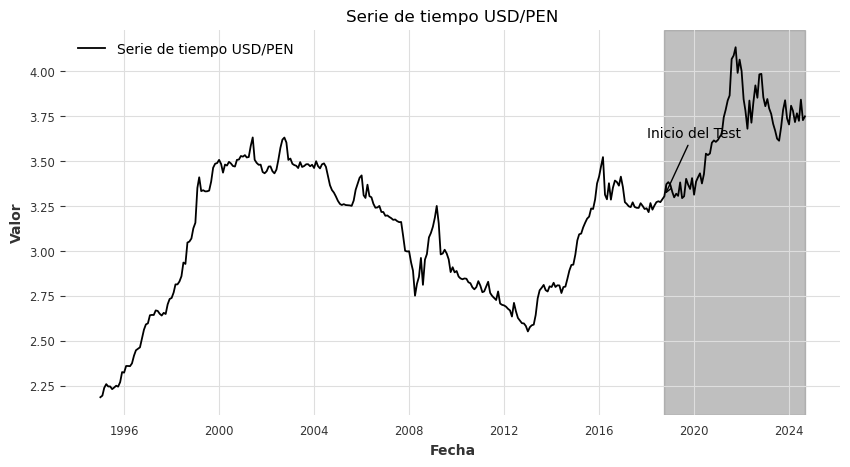

In [22]:
# Suponiendo que df es un DataFrame con índice de tipo datetime
plt.figure(figsize=(10, 5))

# Graficar la serie de tiempo
plt.plot(df, label='Serie de tiempo USD/PEN')

# Etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Valor')

# Sombrear el área de test desde 2018-09-30 hasta el final del DataFrame
plt.axvspan(pd.to_datetime('2018-09-30'), df.index[-1], color='gray', alpha=0.5)

# Anotar el inicio del conjunto de prueba
plt.annotate('Inicio del Test', 
             xy=(pd.to_datetime('2018-09-30'), df.loc['2018-09-30']), # Punto de la anotación
             xytext=(pd.to_datetime('2018-01-01'), df.loc['2018-09-30'] * 1.1), # Posición del texto
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black')

# Título y leyenda
plt.title('Serie de tiempo USD/PEN')
plt.legend()

# Mostrar el gráfico
plt.show()


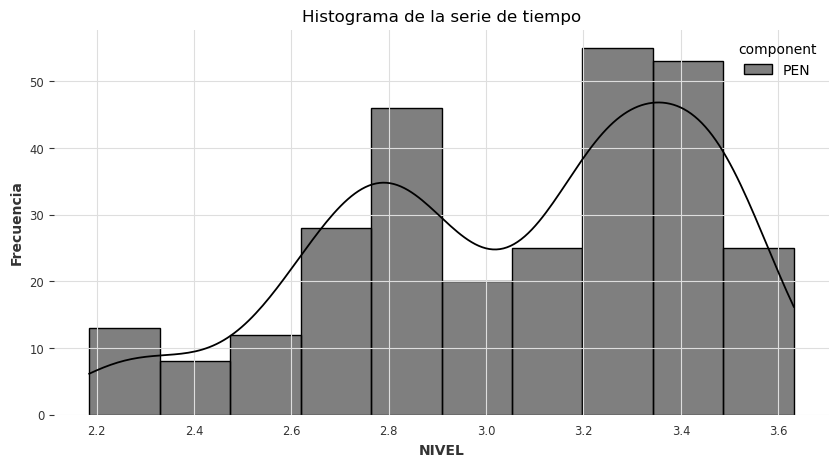

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train, kde=True)  # Ajusta 'valor' al nombre de la columna de la serie de tiempo
plt.title('Histograma de la serie de tiempo')
plt.xlabel('NIVEL')
plt.ylabel('Frecuencia')
plt.show()

In [201]:
q1 = df_train.quantile(0.25)
q2 = df_train.quantile(0.50)  # Esto es equivalente a la mediana
q3 = df_train.quantile(0.75)

print(f"Primer cuartil (Q1): {q1}")
print(f"Mediana (Q2): {q2}")
print(f"Tercer cuartil (Q3): {q3}")

Primer cuartil (Q1): component
PEN    2.79575
Name: 0.25, dtype: float64
Mediana (Q2): component
PEN    3.173
Name: 0.5, dtype: float64
Tercer cuartil (Q3): component
PEN    3.37325
Name: 0.75, dtype: float64


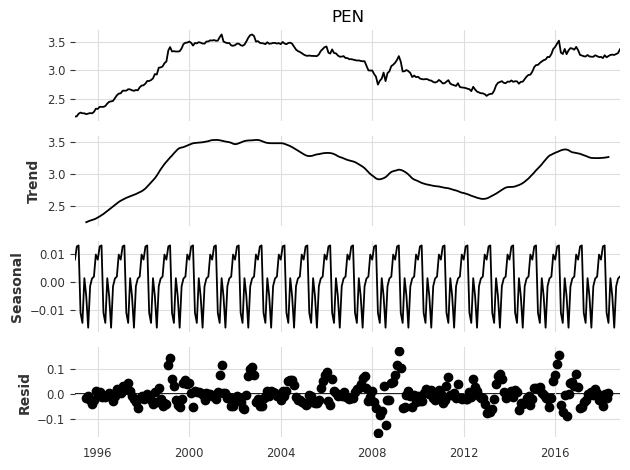

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizamos una descomposición aditiva
result = seasonal_decompose(df_train['PEN'], model='additive', period=12)
result.plot()
plt.show()

# Funciones auxiliares

In [204]:
# Decorador de progreso
def progress_decorator(func):
    def wrapper(*args, **kwargs):
        with tqdm(total=100) as pbar:
            kwargs['progress_bar'] = pbar
            result = func(*args, **kwargs)
        return result
    return wrapper

In [239]:
def evaluate_model(y_true, y_pred):
    # Asegurarse de que y_pred tenga la misma longitud que y_true
    y_pred = y_pred[:len(y_true)]
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [206]:
def save_hyperparameters(params, model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")
    

In [207]:
def load_hyperparameters(model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return None

In [208]:
def save_model(model, model_name):
    filename = f'{model_name}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo guardado en {filename}")



In [2]:
def load_model(model_name):
    filename = f'{model_name}_model.pkl'
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

In [210]:
# 3. Optimización de hiperparámetros (con carga/guardado)
# (Se implementará para cada modelo)

# 4. Entrenamiento de modelos
# (Se implementará para cada modelo)

In [7]:
import pickle

# Abriendo los archivos pickle correctamente
with open('nbeats_forecast_retrain_2.pkl', 'rb') as file:
    nbeats_forecast_retrain_2 = pickle.load(file)

with open('nbeats_forecast_retrain_3.pkl', 'rb') as file:
    nbeats_forecast_retrain_3 = pickle.load(file)

with open('nbeats_forecast_retrain.pkl', 'rb') as file:
    nbeats_forecast_retrain = pickle.load(file)

# Definir una función para obtener las fechas iniciales y finales
# Esto es un ejemplo y depende de cómo sean los objetos
def initial_and_final_dates(model):
    initial_date = getattr(model, 'start_time', None)
    final_date = getattr(model, 'end_time', None)
    
    if callable(initial_date):
        initial_date = initial_date()
    if callable(final_date):
        final_date = final_date()
    
    return initial_date, final_date

# Comparar las fechas de los modelos
for model_name, model in [
    ('nbeats_forecast_retrain_2', nbeats_forecast_retrain_2), 
    ('nbeats_forecast_retrain_3', nbeats_forecast_retrain_3), 
    ('nbeats_forecast_retrain', nbeats_forecast_retrain)
]:
    initial_date, final_date = initial_and_final_dates(model)
    
    # Revisar si las fechas están disponibles
    if initial_date is not None and final_date is not None:
        print(f"Modelo: {model_name}")
        print(f"Fecha inicial: {initial_date}")
        print(f"Fecha final: {final_date}")
    else:
        print(f"Modelo: {model_name}")
        print("No se encontraron las fechas inicial y final.")
    print()


Modelo: nbeats_forecast_retrain_2
Fecha inicial: 2018-11-30 00:00:00
Fecha final: 2024-10-31 00:00:00

Modelo: nbeats_forecast_retrain_3
Fecha inicial: 2018-11-30 00:00:00
Fecha final: 2024-10-31 00:00:00

Modelo: nbeats_forecast_retrain
Fecha inicial: 2018-09-30 00:00:00
Fecha final: 2024-08-31 00:00:00



In [211]:
# Versión mejorada de la función step_by_step_forecast con predicciones adicionales
def step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None, model_name='model', extra_steps=1):
    forecast_filename = f'{model_name}_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    # Intentar cargar la serie forecast si existe
    existing_forecast = None
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            existing_forecast = pickle.load(f)

    # Determinar si necesitamos extender el forecast existente
    if existing_forecast:
        # Comprobamos si el forecast existente cubre hasta el final del test_data
        last_forecast_date = existing_forecast.end_time()
        last_test_date = test_data.end_time()
        
        # Si el forecast existente cubre todas las fechas de test, podemos continuar con los pasos extra
        if last_forecast_date >= last_test_date:
            current_series = train_data.append(existing_forecast)
            start_index = len(test_data)
        else:
            # Si hay nuevos datos, continuamos desde la última fecha del forecast
            print("Extendiéndo forecast con los nuevos datos.")
            current_series = train_data.append(existing_forecast)
            start_index = test_data.time_index.get_loc(last_forecast_date) + 1
    else:
        # Si no hay forecast existente, comenzamos desde el principio
        predictions = []
        current_series = train_data.copy()
        start_index = 0

    # Proseguir con la predicción para los nuevos puntos de datos
    actual_values = test_data.values()
    test_index = test_data.time_index
    freq = pd.infer_freq(test_index)
    if freq is None:
        freq = 'M'
    
    # Crear una lista para las nuevas predicciones
    new_predictions = []

    # Predicción paso a paso desde donde terminamos hasta el final del conjunto de test
    for i in range(start_index, len(test_data)):
        pred = model.predict(n=1, series=current_series)
        new_predictions.append(pred)
        
        new_point = TimeSeries.from_dataframe(
            pd.DataFrame({test_data.components[0]: [actual_values[i]]}, index=[test_index[i]]),
            freq=freq,
            fill_missing_dates=True
        )
        
        current_series = current_series.append(new_point)
        
        if retrain:
            model.fit(current_series, verbose=False)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))

    # Predicción de pasos adicionales fuera del conjunto de test, usando predicción en lote
    if extra_steps > 0:
        print(f"Prediciendo {extra_steps} pasos adicionales fuera del conjunto de prueba...")
        extra_forecast = model.predict(n=extra_steps, series=current_series)
        new_predictions.append(extra_forecast)

    # Concatenar las predicciones nuevas con las anteriores (si las hay)
    if existing_forecast:
        forecast = existing_forecast.concatenate(new_predictions[0])
        for pred in new_predictions[1:]:
            forecast = forecast.concatenate(pred)
    elif new_predictions:
        forecast = new_predictions[0]
        for pred in new_predictions[1:]:
            forecast = forecast.concatenate(pred)
    else:
        raise ValueError("No se generaron nuevas predicciones. Verifica el modelo o los datos de entrada.")
    
    # Guardar la serie forecast actualizada
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [212]:
# 6. Evaluación y comparación de modelos
# (Se implementará después de entrenar todos los modelos)

In [238]:
# 7. Estrategia de trading y retornos acumulados
def implement_trading_strategy(real_returns, predicted_returns):
        # Asegurarse de que y_pred tenga la misma longitud que y_true
    predicted_returns = predicted_returns[:len(real_returns)]
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, pd.Series):
        real_returns_pd = real_returns
    else:
        raise ValueError("real_returns must be either numpy array or pandas Series.")

    if isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = pd.Series(predicted_returns)
    elif isinstance(predicted_returns, pd.Series):
        predicted_returns_pd = predicted_returns
    else:
        raise ValueError("predicted_returns must be either numpy array or pandas Series.")

    # Create the position and calculate strategy returns
    position = pd.Series(np.where(predicted_returns_pd > 0, 1, -1), index=predicted_returns_pd.index)
    strategy_returns = real_returns_pd * position
    
    return strategy_returns



In [214]:
# Transform the serie en returns
def return_series(series):
    if not isinstance(series, pd.Series):
        raise TypeError("La serie debe ser un objeto de tipo pandas.Series para calcular los retornos.")
    return series.pct_change().dropna()

In [215]:
def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1

In [216]:
def calculate_directional_accuracy(y_true, y_pred, method='returns'):
    """
    Calcula la precisión direccional usando diferentes métodos
    
    :param y_true: Valores reales
    :param y_pred: Valores predichos
    :param method: 'returns' o 'differences'
    :return: (accuracy, accuracy_string)
    """
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    if method == 'returns':
        # Calcular retornos
        true_returns = np.diff(y_true) / y_true[:-1]
        pred_returns = np.diff(y_pred) / y_pred[:-1]
        
        # Dirección del movimiento
        true_direction = np.sign(true_returns)
        pred_direction = np.sign(pred_returns)
        
    else:  # method == 'differences'
        # Usar diferencias simples
        true_direction = np.sign(np.diff(y_true))
        pred_direction = np.sign(np.diff(y_pred))
    
    # Calcular precisión
    correct_predictions = np.sum(true_direction == pred_direction)
    total_predictions = len(true_direction)
    
    # Excluir casos donde el valor real no cambió
    valid_movements = np.sum(true_direction != 0)
    if valid_movements > 0:
        accuracy = correct_predictions / valid_movements
    else:
        accuracy = 0.0
    
    accuracy_percentage = accuracy * 100
    accuracy_string = f'Directional Accuracy = {accuracy_percentage:.2f}%'
    
    return accuracy, accuracy_string

In [ ]:
def calculate_performance_metrics(pred_returns, benchmark_returns=None):
    # Asegurarse de que y_pred tenga la misma longitud que y_true
    pred_returns = pred_returns[:len(benchmark_returns)]
    
    # Asegurar que los inputs sean pandas.Series
    if not isinstance(pred_returns, pd.Series):
        pred_returns = pd.Series(pred_returns)
    
    # Crear un benchmark de ceros si no se proporciona uno
    if benchmark_returns is None:
        benchmark_returns = pd.Series([0] * len(pred_returns), index=pred_returns.index)
    elif not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Retornos totales y anualizados
    total_return = (1 + pred_returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

    # Sharpe Ratio (sin tasa libre de riesgo)
    sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

    # Exceso de retornos para Information Ratio
    excess_returns = pred_returns - benchmark_returns
    tracking_error = excess_returns.std()
    information_ratio = excess_returns.mean() / tracking_error

    # Máximo Drawdown
    cumulative_returns = (1 + pred_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns / peak) - 1).min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Information Ratio": information_ratio,
        "Max Drawdown": max_drawdown
    }


In [241]:
def calculate_hit_ratio(y_pred, y_true=None):
    
    """
    Calcula el Hit Ratio entre los valores reales y predichos.
    
    :param y_true: Array o Series con los valores reales, usa y_pred como y_true si no se proporciona
    :param y_pred: Array o Series con los valores predichos
    :return: Tupla con (hit_ratio, hit_ratio_string)
    
    Si y_true no se proporciona, se calculará el hit ratio de y_pred contra sí mismo.
    """
    # Asegurarse de que y_pred tenga la misma longitud que y_true
    y_pred = y_pred[:len(y_true)]
    
    if y_true is None:
        y_true = y_pred
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_true must have the same length.")

    same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_true))
    hit_ratio = same_sign_count / len(y_true) * 100

    hit_ratio_string = f'Hit Ratio = {hit_ratio:.2f}%'
    
    return hit_ratio, hit_ratio_string

In [242]:
# Función para calcular todas las métricas incluyendo Hit Ratio
def calculate_all_metrics(pred_returns,real_returns=None):
    # Asegurarse de que y_pred tenga la misma longitud que y_true
    pred_returns = pred_returns[:len(real_returns)]    
    
    performance_metrics = calculate_performance_metrics(pred_returns,real_returns)
    hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns,real_returns)
    
    all_metrics = {
        **performance_metrics,
        "Hit Ratio": hit_ratio,

    }
    
    return all_metrics

In [220]:
def ensure_numpy_array(data):
    if isinstance(data, TimeSeries):
        return data.values().flatten()
    elif isinstance(data, np.ndarray):
        return data.flatten()
    elif isinstance(data, pd.Series):
        return data.values
    else:
        return np.array(data).flatten()

In [243]:
def evaluate_model_performance(y_true, y_pred, model_name, retrain=False):
    # Asegurarse de que y_pred tenga la misma longitud que y_true
    y_pred = y_pred[:len(y_true)]    
    
    # Handle Darts TimeSeries objects
    if isinstance(y_true, TimeSeries):
        y_true = y_true.values()  # Convert to NumPy array
    if isinstance(y_pred, TimeSeries):
        y_pred = y_pred.values()  # Convert to NumPy array

    # Ensure y_true and y_pred are numpy arrays or pandas Series
    if not isinstance(y_true, (np.ndarray, pd.Series)):
        raise TypeError(f"y_true debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_true)}")
    if not isinstance(y_pred, (np.ndarray, pd.Series)):
        raise TypeError(f"y_pred debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_pred)}")

    # Convert to numpy array if it's a pandas Series
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_np = y_pred.values if isinstance(y_pred, pd.Series) else y_pred

    # Error metrics calculation
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    error_metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Convert to pandas Series for return calculations
    y_true_series = pd.Series(y_true.flatten()) if isinstance(y_true, np.ndarray) else y_true
    y_pred_series = pd.Series(y_pred.flatten()) if isinstance(y_pred, np.ndarray) else y_pred

    # Ensure they are Series before calculating returns
    try:
        y_true_returns = return_series(y_true_series)
        y_pred_returns = return_series(y_pred_series)
    except TypeError as e:
        print(f"Error: {e}")
        return None, None

    # Implement trading strategy
    strategy_returns = implement_trading_strategy(y_true_returns, y_pred_returns)

    # Calculate performance metrics
    performance_metrics = calculate_performance_metrics(strategy_returns, y_true_returns)

    # Calculate Hit Ratio
    hit_ratio, hit_ratio_string = calculate_hit_ratio(y_pred_returns, y_true_returns)

    # Combine all metrics
    all_metrics = {
        "Model": model_name,
        "Retrain": retrain,
        **error_metrics,
        **performance_metrics,
        "Hit Ratio": hit_ratio
    }

    return all_metrics, strategy_returns

# NBeats
Esta clase implementa el modelo NBeats, que es un modelo de redes neuronales que se enfoca en la predicción de series de tiempo. El modelo se basa en la arquitectura de un bloque de NBeats, que consiste en una red feedforward con dos capas ocultas y una capa de salida. La red feedforward se aplica a una serie de tiempo y se entrena para predecir los valores futuros de la serie de tiempo. El modelo NBeats se puede utilizar para predecir series de tiempo univariadas y multivariadas.

In [222]:
# NBEATS Implementation

# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [ ]:
def optimize_nbeats(train_data):
    def objective(trial):
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 6, 24),
            'output_chunk_length': 1,
            'num_stacks': trial.suggest_int('num_stacks', 5, 15),
            'num_blocks': trial.suggest_int('num_blocks', 1, 3),
            'num_layers': trial.suggest_int('num_layers', 2, 6),
            'layer_widths': trial.suggest_categorical('layer_widths', [64, 128, 256]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.3),
            'n_epochs': 20,
            'random_state': 42
        }
        
        try:
            model = NBEATSModel(**params)
            
            backtest = model.historical_forecasts(
                series=train_data,
                start=train_data.time_index[int(len(train_data) * 0.7)],
                forecast_horizon=3,
                stride=3,
                retrain=True,
                verbose=False,
                show_warnings=False
            )
            
            
            # Calcular métricas
            mae_error = mae(train_data.slice_intersect(backtest), backtest)
            
            
            # Guardar métricas
            trial.set_user_attr('mae_original', float(mae_error))

            
            return mae_error
            
        except Exception as e:
            print(f"Error en trial {trial.number}: {str(e)}")
            return float('inf')
    
    # Usar TPESampler para mejor optimización
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    def print_callback(study, trial):
        if trial.number % 2 == 0:
            print(f"\nTrial {trial.number}:")
            print(f"MAE: {trial.user_attrs.get('mae_original', 'N/A'):.6f}")
            print(f"Directional Accuracy: {trial.user_attrs.get('direction_accuracy', 'N/A'):.2f}%")
            print(f"Score combinado: {trial.user_attrs.get('combined_score', 'N/A'):.3f}")
            if trial.number > 0:
                print(f"Mejor hasta ahora: {study.best_value:.3f}")
    
    # Optimizar
    study.optimize(objective, n_trials=40, callbacks=[print_callback])
    
    # Preparar mejores parámetros
    best_params = study.best_params
    best_params.update({
        'output_chunk_length': 1,
        'n_epochs': 100,
        'random_state': 42
    })
    
    # Imprimir métricas finales
    print("\nMejores métricas encontradas:")
    print(f"MAE: {study.best_trial.user_attrs['mae_original']:.6f}")
    print(f"Directional Accuracy: {study.best_trial.user_attrs['direction_accuracy']:.2f}%")
    print(f"Score combinado: {study.best_value:.3f}")
    
    return best_params

In [230]:
def train_nbeats(train_data):
    loaded_params = load_hyperparameters('nbeats')
    if loaded_params is None:
        print("Optimizando hiperparámetros para NBEATS...")
        best_params = optimize_nbeats(train_data)
        save_hyperparameters(best_params, 'nbeats')
    else:
        print("Cargando hiperparámetros guardados para NBEATS...")
        best_params = loaded_params
    
    model = NBEATSModel(**best_params)
    model.fit(train_data, verbose=True)
    save_model(model, 'nbeats')
    return model

In [232]:
# Entrenar modelo NBEATS
nbeats_model = train_nbeats(train_scaled)



[I 2024-11-26 01:42:05,564] A new study created in memory with name: no-name-ecfdb8fa-08c4-4624-ab11-24b5007e639a


Optimizando hiperparámetros para NBEATS...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 01:47:49,471] Trial 0 finished with value: 0.4756970937381414 and parameters: {'input_chunk_length': 13, 'num_stacks': 15, 'num_blocks': 3, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.2598528437324805}. Best is trial 0 with value: 0.4756970937381414.



Trial 0:
MAE: 0.068924
Directional Accuracy: 66.67%
Score combinado: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 01:50:10,592] Trial 1 finished with value: 0.6065418881583747 and parameters: {'input_chunk_length': 17, 'num_stacks': 12, 'num_blocks': 1, 'num_layers': 6, 'layer_widths': 64, 'dropout': 0.055021352956030146}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 01:52:38,873] Trial 2 finished with value: 0.5090885134893908 and parameters: {'input_chunk_length': 11, 'num_stacks': 10, 'num_blocks': 2, 'num_layers': 3, 'layer_widths': 64, 'dropout': 0.1099085529881075}. Best is trial 0 with value: 0.4756970937381414.



Trial 2:
MAE: 0.060605
Directional Accuracy: 55.56%
Score combinado: 0.509
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 01:55:00,999] Trial 3 finished with value: 0.508108376258142 and parameters: {'input_chunk_length': 14, 'num_stacks': 13, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 256, 'dropout': 0.051157237106187456}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:04:16,087] Trial 4 finished with value: 0.5095560838795072 and parameters: {'input_chunk_length': 7, 'num_stacks': 15, 'num_blocks': 3, 'num_layers': 6, 'layer_widths': 256, 'dropout': 0.13204574812188039}. Best is trial 0 with value: 0.4756970937381414.



Trial 4:
MAE: 0.060722
Directional Accuracy: 55.56%
Score combinado: 0.510
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:06:28,272] Trial 5 finished with value: 0.5447964103875725 and parameters: {'input_chunk_length': 8, 'num_stacks': 10, 'num_blocks': 1, 'num_layers': 6, 'layer_widths': 128, 'dropout': 0.15602040635334324}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:09:50,735] Trial 6 finished with value: 0.5792004282034626 and parameters: {'input_chunk_length': 16, 'num_stacks': 7, 'num_blocks': 3, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.27656227050693505}. Best is trial 0 with value: 0.4756970937381414.



Trial 6:
MAE: 0.069800
Directional Accuracy: 50.00%
Score combinado: 0.579
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:11:04,655] Trial 7 finished with value: 0.5576203425988588 and parameters: {'input_chunk_length': 7, 'num_stacks': 7, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 256, 'dropout': 0.10702599800807679}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:13:10,841] Trial 8 finished with value: 0.48593549228179866 and parameters: {'input_chunk_length': 11, 'num_stacks': 10, 'num_blocks': 1, 'num_layers': 6, 'layer_widths': 128, 'dropout': 0.059614704460251716}. Best is trial 0 with value: 0.4756970937381414.



Trial 8:
MAE: 0.071484
Directional Accuracy: 66.67%
Score combinado: 0.486
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:18:59,991] Trial 9 finished with value: 0.5915442355553422 and parameters: {'input_chunk_length': 6, 'num_stacks': 13, 'num_blocks': 3, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.03476071785753891}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:20:09,969] Trial 10 finished with value: 0.6434555505588325 and parameters: {'input_chunk_length': 23, 'num_stacks': 5, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 64, 'dropout': 0.27229943858475536}. Best is trial 0 with value: 0.4756970937381414.



Trial 10:
MAE: 0.077531
Directional Accuracy: 44.44%
Score combinado: 0.643
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:24:16,390] Trial 11 finished with value: 0.60318112844412 and parameters: {'input_chunk_length': 12, 'num_stacks': 15, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 128, 'dropout': 0.20914676950202832}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:28:01,925] Trial 12 finished with value: 0.6085020455319003 and parameters: {'input_chunk_length': 21, 'num_stacks': 8, 'num_blocks': 3, 'num_layers': 5, 'layer_widths': 128, 'dropout': 0.20479350482259226}. Best is trial 0 with value: 0.4756970937381414.



Trial 12:
MAE: 0.068792
Directional Accuracy: 44.44%
Score combinado: 0.609
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:30:44,289] Trial 13 finished with value: 0.5452207045221913 and parameters: {'input_chunk_length': 11, 'num_stacks': 11, 'num_blocks': 2, 'num_layers': 3, 'layer_widths': 128, 'dropout': 0.22265770563696674}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:33:11,107] Trial 14 finished with value: 0.5427555872509674 and parameters: {'input_chunk_length': 19, 'num_stacks': 9, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 128, 'dropout': 0.008427213177998397}. Best is trial 0 with value: 0.4756970937381414.



Trial 14:
MAE: 0.052356
Directional Accuracy: 44.44%
Score combinado: 0.543
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:35:20,945] Trial 15 finished with value: 0.5121807821115378 and parameters: {'input_chunk_length': 13, 'num_stacks': 13, 'num_blocks': 1, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.07799853282768446}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:38:30,137] Trial 16 finished with value: 0.5185501845171869 and parameters: {'input_chunk_length': 10, 'num_stacks': 11, 'num_blocks': 3, 'num_layers': 2, 'layer_widths': 128, 'dropout': 0.15984654286776}. Best is trial 0 with value: 0.4756970937381414.



Trial 16:
MAE: 0.054638
Directional Accuracy: 50.00%
Score combinado: 0.519
Mejor hasta ahora: 0.476


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:41:40,422] Trial 17 finished with value: 0.6658511548694092 and parameters: {'input_chunk_length': 15, 'num_stacks': 14, 'num_blocks': 2, 'num_layers': 3, 'layer_widths': 128, 'dropout': 0.23839360923362674}. Best is trial 0 with value: 0.4756970937381414.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:42:38,786] Trial 18 finished with value: 0.4247110127644479 and parameters: {'input_chunk_length': 18, 'num_stacks': 5, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.18074346913355877}. Best is trial 18 with value: 0.4247110127644479.



Trial 18:
MAE: 0.047844
Directional Accuracy: 61.11%
Score combinado: 0.425
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:44:12,722] Trial 19 finished with value: 0.5297684192805838 and parameters: {'input_chunk_length': 18, 'num_stacks': 5, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.1791032405969888}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:46:36,765] Trial 20 finished with value: 0.9181448465382616 and parameters: {'input_chunk_length': 21, 'num_stacks': 6, 'num_blocks': 3, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.2843327342389226}. Best is trial 18 with value: 0.4247110127644479.



Trial 20:
MAE: 0.154536
Directional Accuracy: 50.00%
Score combinado: 0.918
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:48:08,685] Trial 21 finished with value: 0.560234910439268 and parameters: {'input_chunk_length': 9, 'num_stacks': 8, 'num_blocks': 1, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.23894360668263137}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:49:36,544] Trial 22 finished with value: 0.530678198947382 and parameters: {'input_chunk_length': 14, 'num_stacks': 9, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.18486464538111275}. Best is trial 18 with value: 0.4247110127644479.



Trial 22:
MAE: 0.066003
Directional Accuracy: 55.56%
Score combinado: 0.531
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:51:12,419] Trial 23 finished with value: 0.433268880372873 and parameters: {'input_chunk_length': 19, 'num_stacks': 11, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 256, 'dropout': 0.24900127267873112}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:52:53,891] Trial 24 finished with value: 0.59163379359473 and parameters: {'input_chunk_length': 20, 'num_stacks': 12, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 256, 'dropout': 0.25556215166394075}. Best is trial 18 with value: 0.4247110127644479.



Trial 24:
MAE: 0.072908
Directional Accuracy: 50.00%
Score combinado: 0.592
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:55:38,784] Trial 25 finished with value: 0.5359321000760893 and parameters: {'input_chunk_length': 24, 'num_stacks': 14, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 256, 'dropout': 0.25487075383196445}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:57:14,000] Trial 26 finished with value: 0.7835401022994382 and parameters: {'input_chunk_length': 18, 'num_stacks': 11, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 256, 'dropout': 0.19836330396831353}. Best is trial 18 with value: 0.4247110127644479.



Trial 26:
MAE: 0.112552
Directional Accuracy: 44.44%
Score combinado: 0.784
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 02:58:27,224] Trial 27 finished with value: 0.5644619934303758 and parameters: {'input_chunk_length': 16, 'num_stacks': 6, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 256, 'dropout': 0.29786488411059786}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:02:40,750] Trial 28 finished with value: 0.6899293787880078 and parameters: {'input_chunk_length': 22, 'num_stacks': 14, 'num_blocks': 3, 'num_layers': 3, 'layer_widths': 64, 'dropout': 0.22709132027844678}. Best is trial 18 with value: 0.4247110127644479.



Trial 28:
MAE: 0.080816
Directional Accuracy: 38.89%
Score combinado: 0.690
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:04:27,288] Trial 29 finished with value: 0.5836515138473377 and parameters: {'input_chunk_length': 17, 'num_stacks': 12, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.25422647528596404}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:06:24,657] Trial 30 finished with value: 0.5018014500477019 and parameters: {'input_chunk_length': 19, 'num_stacks': 9, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 256, 'dropout': 0.12971924244200006}. Best is trial 18 with value: 0.4247110127644479.



Trial 30:
MAE: 0.058784
Directional Accuracy: 55.56%
Score combinado: 0.502
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:08:04,341] Trial 31 finished with value: 0.5657256884987669 and parameters: {'input_chunk_length': 13, 'num_stacks': 8, 'num_blocks': 1, 'num_layers': 6, 'layer_widths': 128, 'dropout': 0.08268420127073858}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:09:49,743] Trial 32 finished with value: 0.5398863482700946 and parameters: {'input_chunk_length': 11, 'num_stacks': 10, 'num_blocks': 1, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.18431894522796335}. Best is trial 18 with value: 0.4247110127644479.



Trial 32:
MAE: 0.059972
Directional Accuracy: 50.00%
Score combinado: 0.540
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:10:56,020] Trial 33 finished with value: 0.44704901904145633 and parameters: {'input_chunk_length': 15, 'num_stacks': 6, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.0007612005146103579}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:12:02,123] Trial 34 finished with value: 0.5363738353474128 and parameters: {'input_chunk_length': 16, 'num_stacks': 6, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.12456383428531306}. Best is trial 18 with value: 0.4247110127644479.



Trial 34:
MAE: 0.050760
Directional Accuracy: 44.44%
Score combinado: 0.536
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:13:02,026] Trial 35 finished with value: 0.5674920861424679 and parameters: {'input_chunk_length': 15, 'num_stacks': 5, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 64, 'dropout': 0.0022901000398182986}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:14:07,355] Trial 36 finished with value: 0.50388773932979 and parameters: {'input_chunk_length': 17, 'num_stacks': 7, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 64, 'dropout': 0.14786592165085605}. Best is trial 18 with value: 0.4247110127644479.



Trial 36:
MAE: 0.050972
Directional Accuracy: 50.00%
Score combinado: 0.504
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:15:14,147] Trial 37 finished with value: 0.5984994358491346 and parameters: {'input_chunk_length': 14, 'num_stacks': 6, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 256, 'dropout': 0.29652498687738593}. Best is trial 18 with value: 0.4247110127644479.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:16:20,423] Trial 38 finished with value: 0.6254686416032128 and parameters: {'input_chunk_length': 18, 'num_stacks': 5, 'num_blocks': 1, 'num_layers': 5, 'layer_widths': 64, 'dropout': 0.10803759633201322}. Best is trial 18 with value: 0.4247110127644479.



Trial 38:
MAE: 0.089700
Directional Accuracy: 55.56%
Score combinado: 0.625
Mejor hasta ahora: 0.425


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 03:18:49,728] Trial 39 finished with value: 0.5284163218825906 and parameters: {'input_chunk_length': 20, 'num_stacks': 7, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 256, 'dropout': 0.17033578889501017}. Best is trial 18 with value: 0.4247110127644479.



Mejores métricas encontradas:
MAE: 0.047844
Directional Accuracy: 61.11%
Score combinado: 0.425
Hiperparámetros guardados en best_hyperparameters_nbeats.json


Training: |          | 0/? [00:00<?, ?it/s]

Modelo guardado en nbeats_model.pkl


In [233]:
# Uso de step_by_step_forecast sin reentrenamiento (como lo hicimos antes)
nbeats_forecast_no_retrain = step_by_step_forecast(nbeats_model, train_scaled, test_scaled, retrain=False, model_name='nbeats')

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Prediciendo 1 pasos adicionales fuera del conjunto de prueba...


Predicting: |          | 0/? [00:00<?, ?it/s]

Guardando forecast en nbeats_forecast_no_retrain.pkl


In [234]:
# Uso de step_by_step_forecast con reentrenamiento
nbeats_forecast_with_retrain = step_by_step_forecast(nbeats_model, train_scaled, test_scaled, retrain=True, model_name='nbeats')

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Prediciendo 1 pasos adicionales fuera del conjunto de prueba...


Predicting: |          | 0/? [00:00<?, ?it/s]

Guardando forecast en nbeats_forecast_retrain.pkl


In [244]:
# Desescalar las predicciones
nbeats_forecast_no_retrain_unscaled = scaler.inverse_transform(nbeats_forecast_no_retrain)
nbeats_forecast_with_retrain_unscaled = scaler.inverse_transform(nbeats_forecast_with_retrain)

In [245]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = nbeats_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = nbeats_forecast_with_retrain_unscaled.values().flatten()

nbeats_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
nbeats_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo NBEATS sin reentrenamiento:")
for metric, value in nbeats_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo NBEATS con reentrenamiento:")
for metric, value in nbeats_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo NBEATS sin reentrenamiento:
MSE: 0.007668
RMSE: 0.087570
MAE: 0.067547
R2: 0.845864

Evaluación del modelo NBEATS con reentrenamiento:
MSE: 0.007610
RMSE: 0.087237
MAE: 0.070362
R2: 0.847033


In [248]:
y_pred_with_retrain

array([3.3484372 , 3.37008968, 3.34929759, 3.34580268, 3.30431322,
       3.32663943, 3.30025341, 3.38316091, 3.27700108, 3.30903517,
       3.40125922, 3.35831184, 3.31456449, 3.41253307, 3.32992167,
       3.39819648, 3.39705757, 3.40413865, 3.38575119, 3.41105239,
       3.43099078, 3.47020567, 3.48017627, 3.48064877, 3.57257109,
       3.55353579, 3.55685242, 3.61433639, 3.64188589, 3.72727576,
       3.81561744, 3.9160732 , 3.90605824, 4.20424949, 4.11543636,
       4.19037494, 4.02474819, 4.05853993, 4.06439553, 3.78285679,
       3.75138648, 3.63103781, 3.92005119, 3.77804988, 3.87464232,
       3.99404022, 3.87236061, 4.06387901, 3.98323742, 3.88936612,
       3.75459268, 3.82693459, 3.73845193, 3.72328681, 3.70460435,
       3.65465574, 3.6674231 , 3.66369241, 3.74726977, 3.81506567,
       3.87908588, 3.7516253 , 3.69098758, 3.83952972, 3.71877323,
       3.70024488, 3.75689662, 3.71448605, 3.78318478, 3.70455938,
       3.80920636, 3.65886919, 3.77324424])

In [250]:
nbeats_forecast_with_retrain_unscaled.time_index

DatetimeIndex(['2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31', '2023-01-31', '2023-02-28',
               '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30',
      

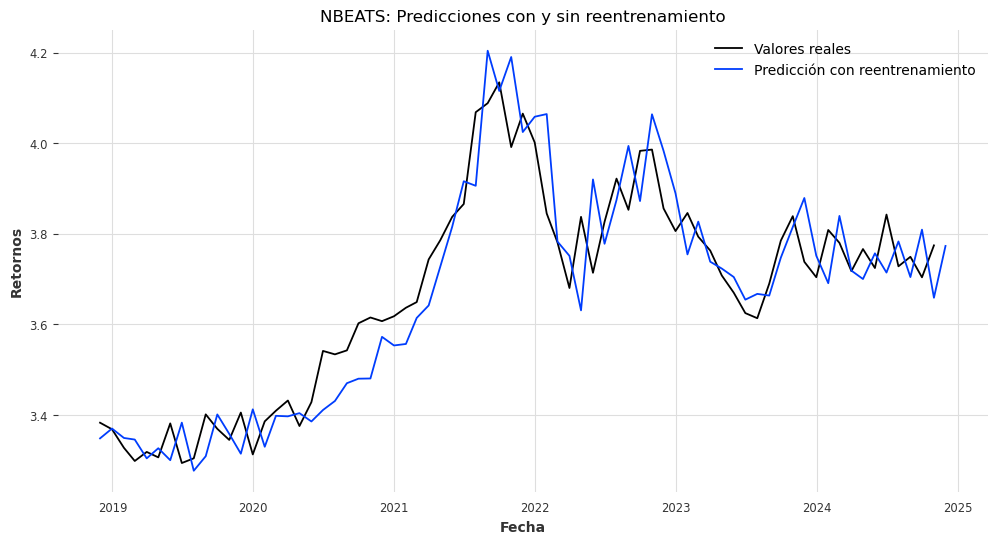

In [251]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
#plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(nbeats_forecast_with_retrain_unscaled.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('NBEATS: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [252]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(nbeats_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(nbeats_forecast_with_retrain_unscaled.pd_series())

In [253]:
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [254]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

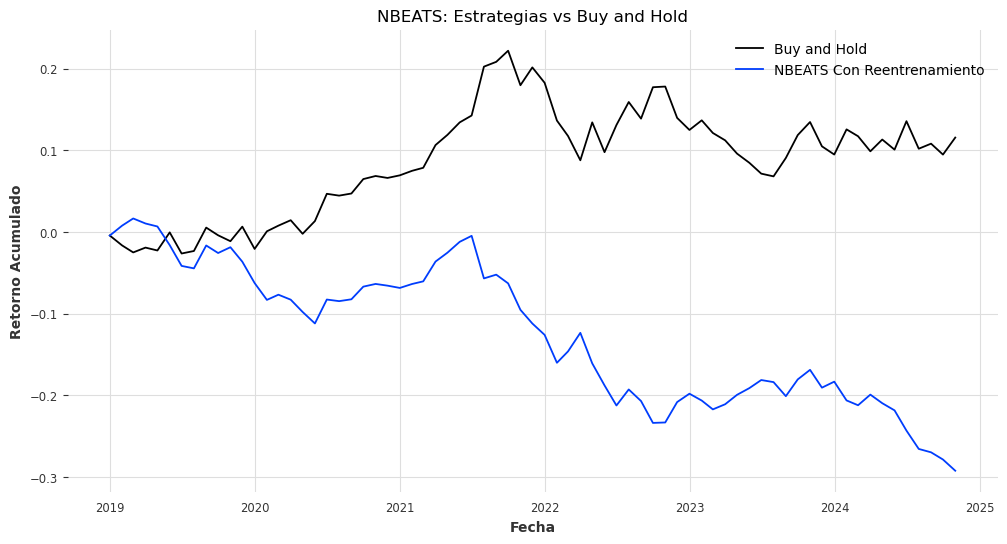

In [255]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
#plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='NBEATS Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='NBEATS Con Reentrenamiento')
plt.legend()
plt.title('NBEATS: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [ ]:
hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns_with_retrain, real_returns)

In [ ]:
hit_ratio_string

'Hit Ratio = 42.25%'

# NHITS (NBeats Hierarchical Iterative Time Series)
Esta clase implementa el modelo NHITS, que es un modelo de redes neuronales que se enfoca en la predicción de series de tiempo. El modelo se basa en la arquitectura de un bloque de NBeats, que consiste en una red feedforward con dos capas ocultas y una capa de salida. La red feedforward se aplica a una serie de tiempo y se entrena para predecir los valores futuros de la serie de tiempo. El modelo NHITS se puede utilizar para predecir series de tiempo univariadas y multivariadas.

In [258]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_nhits(train_data):
    def objective(trial):
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 6, 24),
            'output_chunk_length': 1,
            'num_stacks': trial.suggest_int('num_stacks', 2, 8),
            'num_blocks': trial.suggest_int('num_blocks', 1, 3),
            'num_layers': trial.suggest_int('num_layers', 2, 4),
            'layer_widths': trial.suggest_categorical('layer_widths', [64, 128, 256]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.3),
            'n_epochs': 20,
            'random_state': 42
        }
        
        try:
            model = NHiTSModel(**params)
            
            backtest = model.historical_forecasts(
                series=train_data,
                start=train_data.time_index[int(len(train_data) * 0.7)],
                forecast_horizon=3,
                stride=3,
                retrain=True,
                verbose=False,
                show_warnings=False
            )
            
            actual_values = train_data.slice_intersect(backtest).values()
            predicted_values = backtest.values()
            
            # Calculate metrics
            mae_error = mae(train_data.slice_intersect(backtest), backtest)
            
            
            # Save metrics
            trial.set_user_attr('mae_original', float(mae_error))

            
            return mae_error
            
        except Exception as e:
            print(f"Error in trial {trial.number}: {str(e)}")
            return float('inf')
    
    # Use TPESampler for better optimization
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    def print_callback(study, trial):
        if trial.number % 2 == 0:
            print(f"\nTrial {trial.number}:")
            print(f"MAE: {trial.user_attrs.get('mae_original', 'N/A'):.6f}")
            if trial.number > 0:
                print(f"Best so far: {study.best_value:.3f}")
    
    # Optimize with more trials for better results
    study.optimize(objective, n_trials=40, callbacks=[print_callback])
    
    # Prepare best parameters
    best_params = study.best_params
    best_params.update({
        'output_chunk_length': 1,
        'n_epochs': 100,
        'random_state': 42
    })
    
    # Print final metrics
    print("\nBest metrics found:")
    print(f"MAE: {study.best_trial.user_attrs['mae_original']:.6f}")
    
    return best_params


In [260]:
# Entrenamiento del modelo
def train_nhits(train_data):
    loaded_params = load_hyperparameters('nhits')
    if loaded_params is None:
        print("Optimizando hiperparámetros para NHITS...")
        best_params = optimize_nhits(train_data)
        save_hyperparameters(best_params, 'nhits')
    else:
        print("Cargando hiperparámetros guardados para NHITS...")
        best_params = loaded_params
    
    model = NHiTSModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'nhits')
    return model

In [261]:
# Entrenar modelo NHITS
nhits_model = train_nhits(train_scaled)

[I 2024-11-26 08:09:09,225] A new study created in memory with name: no-name-e13e321e-16ce-4f20-b916-48b4e6ab2e61


Optimizando hiperparámetros para NHITS...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-26 08:10:38,685] Trial 0 finished with value: inf and parameters: {'input_chunk_length': 13, 'num_stacks': 8, 'num_blocks': 3, 'num_layers': 3, 'layer_widths': 64, 'dropout': 0.2598528437324805}. Best is trial 0 with value: inf.


Error in trial 0: name 'exit' is not defined

Trial 0:


ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
# Realizar rolling forecast
nhits_forecast_no_retrain = step_by_step_forecast(nhits_model, train_scaled, test_scaled, retrain=False, model_name='nhits')


Cargando forecast guardado de nhits_forecast_no_retrain.pkl


In [ ]:
nhits_forecast_with_retrain = step_by_step_forecast(nhits_model, train_scaled, test_scaled, retrain=True, model_name='nhits')

Cargando forecast guardado de nhits_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones
nhits_forecast_no_retrain_unscaled = scaler.inverse_transform(nhits_forecast_no_retrain)
nhits_forecast_with_retrain_unscaled = scaler.inverse_transform(nhits_forecast_with_retrain)

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = nhits_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = nhits_forecast_with_retrain_unscaled.values().flatten()

nhits_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
nhits_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

In [ ]:
print("Evaluación del modelo NHITS sin reentrenamiento:")
for metric, value in nhits_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo NHITS con reentrenamiento:")
for metric, value in nhits_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo NHITS sin reentrenamiento:
MSE: 0.012973
RMSE: 0.113899
MAE: 0.085447
R2: 0.753167

Evaluación del modelo NHITS con reentrenamiento:
MSE: 0.007459
RMSE: 0.086364
MAE: 0.070187
R2: 0.858083


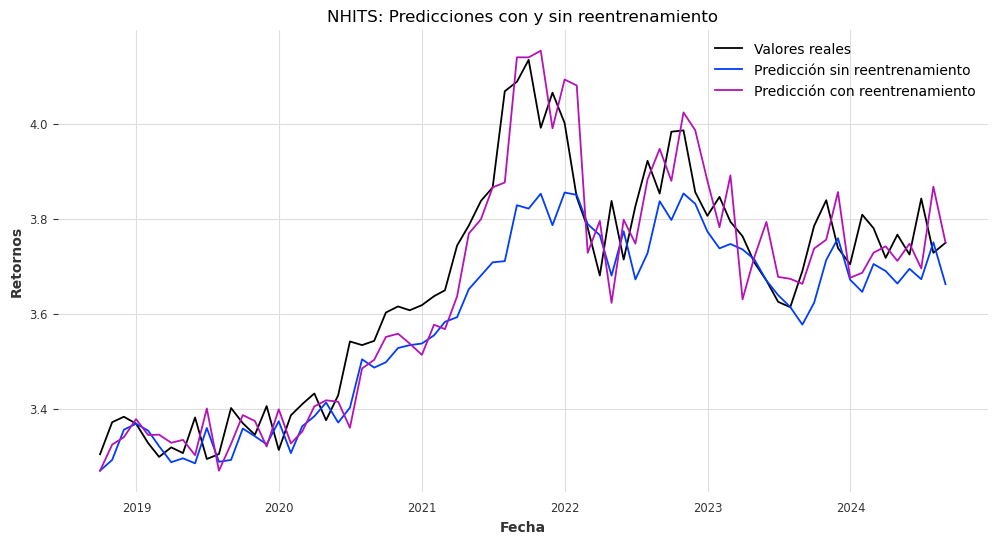

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
#plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(nhits_forecast_with_retrain_unscaled.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('NHITS: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(nhits_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(nhits_forecast_with_retrain_unscaled.pd_series())

strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [ ]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)


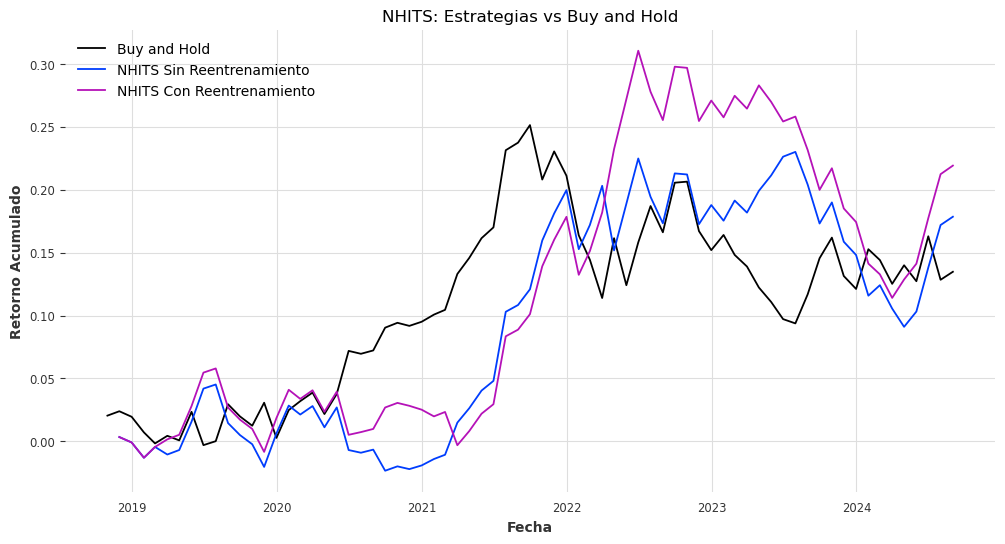

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
#plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='NHITS Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='NHITS Con Reentrenamiento')
plt.legend()
plt.title('NHITS: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

# AUTOARIMA

In [ ]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def autoarima_step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None):
    forecast_filename = f'autoarima_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    # Intentar cargar la serie forecast si existe
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    current_series = train_data.copy()
    actual_values = test_data.values()
    test_index = test_data.time_index
    
    freq = pd.infer_freq(test_index)
    if freq is None:
        freq = 'M'
    
    for i in range(len(test_data)):
        pred = model.predict(n=1)
        predictions.append(pred)
        
        new_point = TimeSeries.from_dataframe(
            pd.DataFrame({test_data.components[0]: [actual_values[i]]}, index=[test_index[i]]),
            freq=freq,
            fill_missing_dates=True
        )
        
        current_series = current_series.append(new_point)
        
        if retrain:
            model.fit(current_series)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    if predictions:
        # Concatenar todas las predicciones
        forecast_values = np.concatenate([pred.values() for pred in predictions])
        
        # Crear un nuevo TimeSeries con los valores pronosticados y el índice de tiempo correcto
        forecast = TimeSeries.from_times_and_values(
            times=test_data.time_index,
            values=forecast_values,
            freq=freq
        )
    else:
        # En lugar de devolver un TimeSeries vacío, lanzar una advertencia o excepción
        raise ValueError("No se generaron predicciones. Verifica el modelo o los datos de entrada.")
    
    # Guardar la serie forecast
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity_and_differencing(series, alpha=0.05, max_diff=5):
    """
    Test series for stationarity using the Augmented Dickey-Fuller test and determine the number of differencing needed.
    
    Parameters:
        series (pd.Series or np.ndarray): The time series data.
        alpha (float): The significance level to determine stationarity.
        max_diff (int): Maximum number of differencing steps to test.
    
    Returns:
        int: The number of differencing steps suggested.
        pd.Series: The differenced series that passed the ADF test.
    """
    # Ensure series is a pandas Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Apply ADF test iteratively
    for d in range(max_diff + 1):
        if d > 0:
            # Difference the series
            diff_series = series.diff(periods=d).dropna()
        else:
            diff_series = series
        
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]  # p-value
        
        print(f"Differencing level {d}: ADF Statistic: {adf_result[0]}, p-value: {p_value}")
        
        # Check if the series is stationary
        if p_value < alpha:
            print(f"Series is stationary after {d} differencing step(s).")
            return d, diff_series
    
    print("Series is not stationary even after maximum allowed differencing.")
    return d, diff_series

diferencias, diff_series = test_stationarity_and_differencing(df['PEN'], max_diff=5)

Differencing level 0: ADF Statistic: -2.00501168406024, p-value: 0.2843799830877552
Differencing level 1: ADF Statistic: -18.935663197488175, p-value: 0.0
Series is stationary after 1 differencing step(s).


In [ ]:
def train_autoarima(train_data,diferencias):
    # Configuración del modelo AutoARIMA para una serie mensual
    model = AutoARIMA(
        d=diferencias,
        start_p=1,
        start_q=1,
        max_p=5,
        max_q=5,
        seasonal=True,
        seasonal_periods=12,  # Periodo estacional de 12 meses
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        random_state=42,
    )

    print("Entrenando modelo AutoARIMA para serie mensual...")
    model.fit(train_data)
    save_model(model, 'autoarima')
    return model

In [ ]:
# Entrenar modelo AutoARIMA
autoarima_model = train_autoarima(train_scaled,diferencias)


Entrenando modelo AutoARIMA para serie mensual...
Modelo guardado en autoarima_model.pkl


In [ ]:
modelo_subyacente = autoarima_model.model
# Imprime el resumen del modelo
print(modelo_subyacente.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  285
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 592.853
Date:                Sun, 10 Nov 2024   AIC                          -1179.706
Time:                        02:17:15   BIC                          -1168.759
Sample:                             0   HQIC                         -1175.317
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9660      0.039     25.078      0.000       0.890       1.041
ma.L1         -0.9227      0.057    -16.048      0.000      -1.035      -0.810
sigma2         0.0009   4.45e-05     20.225      0.0

In [ ]:
# Realizar rolling forecast
autoarima_forecast_no_retrain = autoarima_step_by_step_forecast(autoarima_model, train_scaled, test_scaled, retrain=False)


Cargando forecast guardado de autoarima_forecast_no_retrain.pkl


In [ ]:
autoarima_forecast_with_retrain = autoarima_step_by_step_forecast(autoarima_model, train_scaled, test_scaled, retrain=True)

Cargando forecast guardado de autoarima_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones
autoarima_forecast_no_retrain_unscaled = scaler.inverse_transform(autoarima_forecast_no_retrain)
autoarima_forecast_with_retrain_unscaled = scaler.inverse_transform(autoarima_forecast_with_retrain)

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = autoarima_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = autoarima_forecast_with_retrain_unscaled.values().flatten()

autoarima_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
autoarima_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

In [ ]:
print("Evaluación del modelo AutoARIMA sin reentrenamiento:")
for metric, value in autoarima_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo AutoARIMA con reentrenamiento:")
for metric, value in autoarima_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo AutoARIMA sin reentrenamiento:
MSE: 0.189170
RMSE: 0.434936
MAE: 0.369611
R2: -2.599289

Evaluación del modelo AutoARIMA con reentrenamiento:
MSE: 0.005463
RMSE: 0.073915
MAE: 0.059149
R2: 0.896048


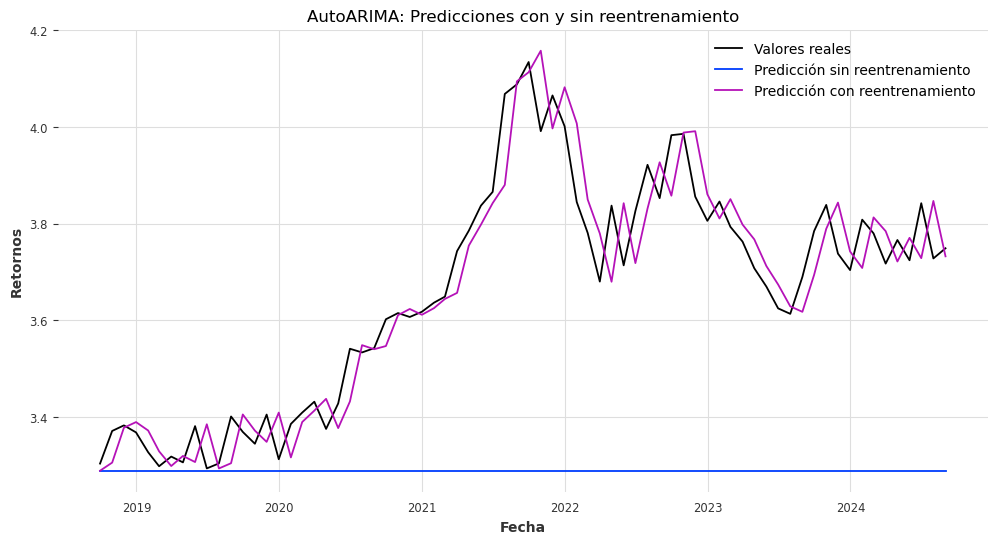

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('AutoARIMA: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(autoarima_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(autoarima_forecast_with_retrain_unscaled.pd_series())

In [ ]:
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [ ]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

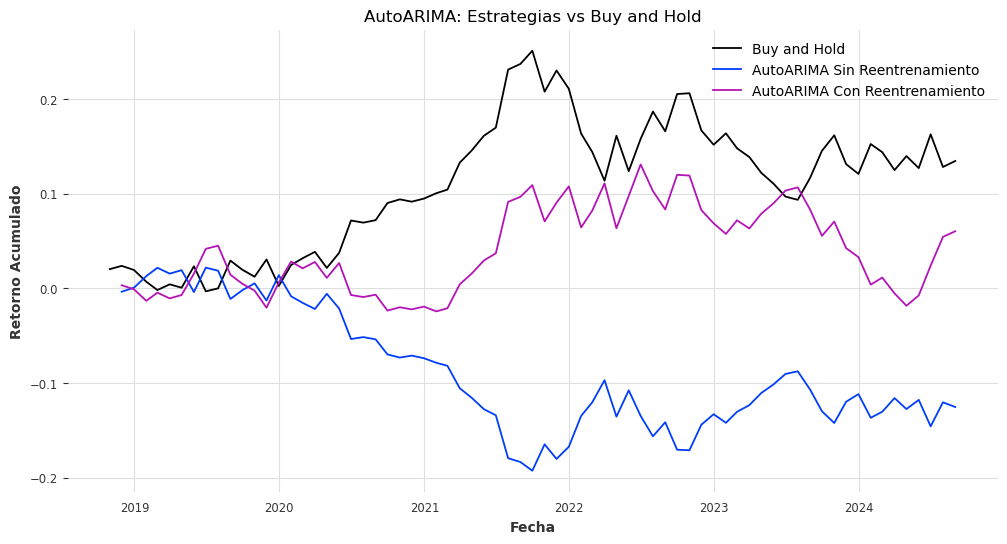

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='AutoARIMA Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='AutoARIMA Con Reentrenamiento')
plt.legend()
plt.title('AutoARIMA: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [ ]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia AutoARIMA sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia AutoARIMA con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia AutoARIMA sin reentrenamiento:
Total Return: -0.1253
Annualized Return: -0.0224
Sharpe Ratio: -0.2976
Information Ratio: -0.0859
Max Drawdown: -0.2101
Hit Ratio: 0.0000

Estrategia AutoARIMA con reentrenamiento:
Total Return: 0.0605
Annualized Return: 0.0100
Sharpe Ratio: 0.1796
Information Ratio: -0.0249
Max Drawdown: -0.1321
Hit Ratio: 54.9296


In [ ]:
autoarima_metrics_no_retrain, autoarima_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "AUTOARIMA", retrain=False)

autoarima_metrics_with_retrain, autoarima_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "AUTOARIMA", retrain=True)

# TSMixer

In [ ]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_tsmixer(train_data):
    def objective(trial):
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 12, 72),
            'output_chunk_length': 1,
            'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128, 256]),
            'ff_size': trial.suggest_categorical('ff_size', [64, 128, 256, 512]),
            'num_blocks': trial.suggest_int('num_blocks', 1, 4),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'n_epochs': 20,
            'random_state': 42
        }
        
        try:
            model = TSMixerModel(**params)
            
            backtest = model.historical_forecasts(
                series=train_data,
                start=train_data.time_index[int(len(train_data) * 0.7)],
                forecast_horizon=3,
                stride=3,
                retrain=True,
                verbose=False,
                show_warnings=False
            )
            
            actual_values = train_data.slice_intersect(backtest).values()
            predicted_values = backtest.values()
            
            # Calculate metrics
            mae_error = mae(train_data.slice_intersect(backtest), backtest)
            direction_score, direction_string = calculate_directional_accuracy(actual_values, predicted_values, method='returns')
            
            # Normalize MAE
            mae_normalized = mae_error / 0.6
            
            # Combine metrics with more weight on direction
            combined_error = 0.5 * mae_normalized + 0.5 * (1 - direction_score)
            
            # Save metrics
            trial.set_user_attr('mae_original', float(mae_error))
            trial.set_user_attr('direction_accuracy', direction_string)
            trial.set_user_attr('combined_score', float(combined_error))
            
            return combined_error
            
        except Exception as e:
            print(f"Error in trial {trial.number}: {str(e)}")
            return float('inf')
    
    # Use TPESampler for better optimization
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    def print_callback(study, trial):
        if trial.number % 2 == 0:
            print(f"\nTrial {trial.number}:")
            print(f"MAE: {trial.user_attrs.get('mae_original', 'N/A'):.6f}")
            print(f"Direction Accuracy: {trial.user_attrs.get('direction_accuracy', 'N/A')}")
            print(f"Combined Score: {trial.user_attrs.get('combined_score', 'N/A'):.3f}")
            if trial.number > 0:
                print(f"Best so far: {study.best_value:.3f}")
    
    # Optimize with more trials for better results
    study.optimize(objective, n_trials=40, callbacks=[print_callback])
    
    # Prepare best parameters
    best_params = study.best_params
    best_params.update({
        'output_chunk_length': 1,
        'n_epochs': 100,
        'random_state': 42
    })
    
    # Print final metrics
    print("\nBest metrics found:")
    print(f"MAE: {study.best_trial.user_attrs['mae_original']:.6f}")
    print(f"Direction Accuracy: {study.best_trial.user_attrs['direction_accuracy']}")
    print(f"Combined Score: {study.best_value:.3f}")
    
    return best_params

In [ ]:
def train_tsmixer(train_data):
    loaded_params = load_hyperparameters('tsmixer')
    if loaded_params is None:
        print("Optimizando hiperparámetros para TSMixer...")
        best_params = optimize_tsmixer(train_data)
        save_hyperparameters(best_params, 'tsmixer')
    else:
        print("Cargando hiperparámetros guardados para TSMixer...")
        best_params = loaded_params
    
    model = TSMixerModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'tsmixer')
    return model

In [ ]:
# Entrenar modelo TSMixer
tsmixer_model = train_tsmixer(train_scaled)

Cargando hiperparámetros guardados para TSMixer...
Modelo guardado en tsmixer_model.pkl


In [ ]:
# Realizar rolling forecast
tsmixer_forecast_no_retrain = step_by_step_forecast(tsmixer_model, train_scaled, test_scaled, retrain=False, model_name='tsmixer')

Cargando forecast guardado de tsmixer_forecast_no_retrain.pkl


In [ ]:
tsmixer_forecast_with_retrain = step_by_step_forecast(tsmixer_model, train_scaled, test_scaled, retrain=True, model_name='tsmixer')

Cargando forecast guardado de tsmixer_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones
tsmixer_forecast_no_retrain_unscaled = scaler.inverse_transform(tsmixer_forecast_no_retrain)
tsmixer_forecast_with_retrain_unscaled = scaler.inverse_transform(tsmixer_forecast_with_retrain)

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = tsmixer_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = tsmixer_forecast_with_retrain_unscaled.values().flatten()

tsmixer_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
tsmixer_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo TSMixer sin reentrenamiento:")
for metric, value in tsmixer_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo TSMixer con reentrenamiento:")
for metric, value in tsmixer_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo TSMixer sin reentrenamiento:
MSE: 0.040648
RMSE: 0.201612
MAE: 0.165354
R2: 0.226608

Evaluación del modelo TSMixer con reentrenamiento:
MSE: 0.007794
RMSE: 0.088283
MAE: 0.071388
R2: 0.851707


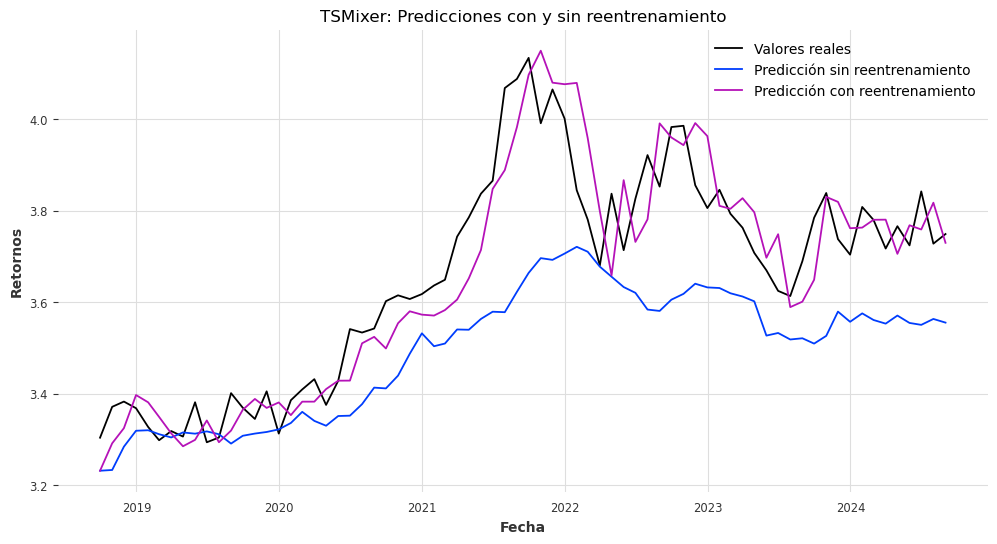

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
#plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(tsmixer_evaluation_with_retrain.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('TSMixer: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(tsmixer_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(tsmixer_forecast_with_retrain_unscaled.pd_series())

strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [ ]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

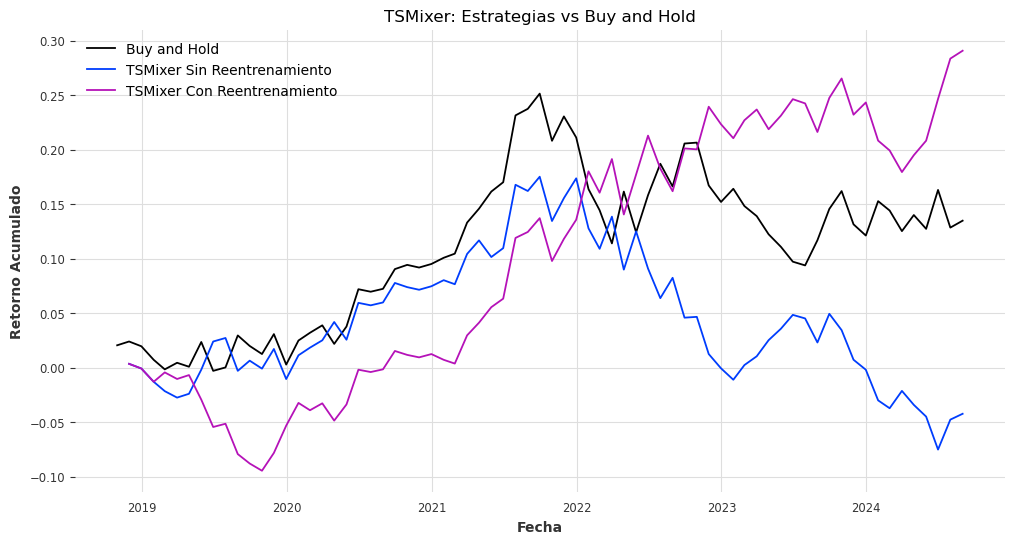

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
#plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='TSMixer Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='TSMixer Con Reentrenamiento')
plt.legend()
plt.title('TSMixer: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

# CatBoost Regressor

In [ ]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
pen = df[['PEN']][train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def create_features(df, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    """Create time series features based on lags."""
    X = df[['PEN']].copy()
    
    # Crear características de lag
    for lag in lags:
        X[f'lag_{lag}'] = X['PEN'].shift(lag)
    
    # Añadir características temporales
    X['month'] = X.index.month
    X['year'] = X.index.year
    
    # Separar target (y) y features (X)
    y = X['PEN']
    X = X.drop(columns=['PEN'])
    
    return X, y

In [ ]:
def optimize_catboost(X_train, y_train, X_val, y_val):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
            'random_strength': trial.suggest_uniform('random_strength', 0.1, 10.0),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
            'loss_function': 'RMSE',
            'random_state': 42
        }

        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

        predictions = model.predict(X_val)
        mse = np.mean((y_val - predictions) ** 2)
        return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    best_params['loss_function'] = 'RMSE'
    best_params['random_state'] = 42

    return best_params


In [ ]:
def train_catboost(df):
    # Crear las características
    X, y = create_features(df)
    
    # Eliminar filas con NaN (causadas por los lags)
    X = X.dropna()
    y = y[X.index]
    
    # Separar datos en entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Separar datos de entrenamiento en train y validación
    val_size = int(len(X_train) * 0.2)
    X_train_opt, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train_opt, y_val = y_train[:-val_size], y_train[-val_size:]
    
    # Escalar las características (excepto month y year)
    scaler = StandardScaler()
    numeric_cols = [col for col in X.columns if col.startswith('lag_')]
    
    # Escalar datos de entrenamiento
    X_train_scaled = X_train_opt.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_opt[numeric_cols])
    X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    # Optimizar hiperparámetros
    loaded_params = load_hyperparameters('catboost')
    if loaded_params is None:
        print("Optimizando hiperparámetros para CatBoost...")
        best_params = optimize_catboost(X_train_scaled, y_train_opt, X_val_scaled, y_val)
        save_hyperparameters(best_params, 'catboost')
    else:
        print("Cargando hiperparámetros guardados para CatBoost...")
        best_params = loaded_params

    # Entrenar el modelo final con todos los datos de entrenamiento
    X_train_full_scaled = X_train.copy()
    X_train_full_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
    
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_full_scaled, y_train, verbose=100)
    
    save_model(model, 'catboost')
    
    return model, X_test_scaled, y_test, scaler


In [ ]:
# Entrenar modelo
catboost_model, X_test_scaled, y_test, scaler = train_catboost(df)

Cargando hiperparámetros guardados para CatBoost...


0:	learn: 0.3201631	total: 132ms	remaining: 1m 30s
100:	learn: 0.0625439	total: 220ms	remaining: 1.28s
200:	learn: 0.0415280	total: 282ms	remaining: 682ms
300:	learn: 0.0318927	total: 335ms	remaining: 431ms
400:	learn: 0.0249719	total: 388ms	remaining: 278ms
500:	learn: 0.0202036	total: 448ms	remaining: 167ms
600:	learn: 0.0164822	total: 518ms	remaining: 75ms
687:	learn: 0.0141416	total: 599ms	remaining: 0us
Modelo guardado en catboost_model.pkl


In [ ]:
def catboost_step_by_step_forecast(model, train_data, test_data, scaler, retrain=False, progress_bar=None):
    """
    Realiza predicciones paso a paso usando el modelo CatBoost.
    """
    forecast_filename = f'catboost_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    # Crear una copia explícita del DataFrame completo
    current_series = train_data.copy(deep=True)
    
    for i in range(len(test_data)):
        # Crear características para la predicción actual
        X_current, _ = create_features(current_series)
        X_current = X_current.dropna()
        
        if len(X_current) > 0:
            # Obtener las características más recientes
            latest_features = X_current.iloc[-1:].copy()
            
            # Escalar solo las características numéricas
            numeric_cols = [col for col in latest_features.columns if col.startswith('lag_')]
            if numeric_cols:
                # Usar loc para modificar el DataFrame
                latest_features.loc[:, numeric_cols] = scaler.transform(latest_features[numeric_cols])
            
            # Realizar predicción
            pred = model.predict(latest_features)
            predictions.append(pred[0])
        else:
            # Si no hay suficientes datos para crear características, usar el último valor
            predictions.append(current_series['PEN'].iloc[-1])
        
        # Actualizar la serie actual con el valor real
        new_data = pd.DataFrame({'PEN': [test_data.iloc[i]['PEN']]},
                              index=[test_data.index[i]])
        current_series = pd.concat([current_series, new_data])
        
        # Reentrenar si es necesario
        if retrain:
            X_train, y_train = create_features(current_series)
            X_train = X_train.dropna()
            y_train = y_train[X_train.index]
            
            # Escalar características numéricas
            numeric_cols = [col for col in X_train.columns if col.startswith('lag_')]
            if numeric_cols:
                # Usar loc para modificar el DataFrame
                X_train.loc[:, numeric_cols] = scaler.transform(X_train[numeric_cols])
            
            model.fit(X_train, y_train, verbose=False)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    predictions = np.array(predictions)
    
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(predictions, f)
    
    return predictions

In [ ]:
# Realizar predicciones
catboost_forecast_no_retrain = catboost_step_by_step_forecast(
    catboost_model, df[:train_size], df[train_size:], scaler, retrain=False)
catboost_forecast_with_retrain = catboost_step_by_step_forecast(
    catboost_model, df[:train_size], df[train_size:], scaler, retrain=True)

Cargando forecast guardado de catboost_forecast_no_retrain.pkl
Cargando forecast guardado de catboost_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones
catboost_forecast_no_retrain_unscaled = catboost_forecast_no_retrain
catboost_forecast_with_retrain_unscaled = catboost_forecast_with_retrain

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = catboost_forecast_no_retrain_unscaled.flatten()
y_pred_with_retrain = catboost_forecast_with_retrain_unscaled.flatten()

catboost_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
catboost_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo CatBoost sin reentrenamiento:")
for metric, value in catboost_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo CatBoost con reentrenamiento:")
for metric, value in catboost_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo CatBoost sin reentrenamiento:
MSE: 0.004422
RMSE: 0.066499
MAE: 0.054363
R2: 0.915860

Evaluación del modelo CatBoost con reentrenamiento:
MSE: 0.005393
RMSE: 0.073436
MAE: 0.060135
R2: 0.897390


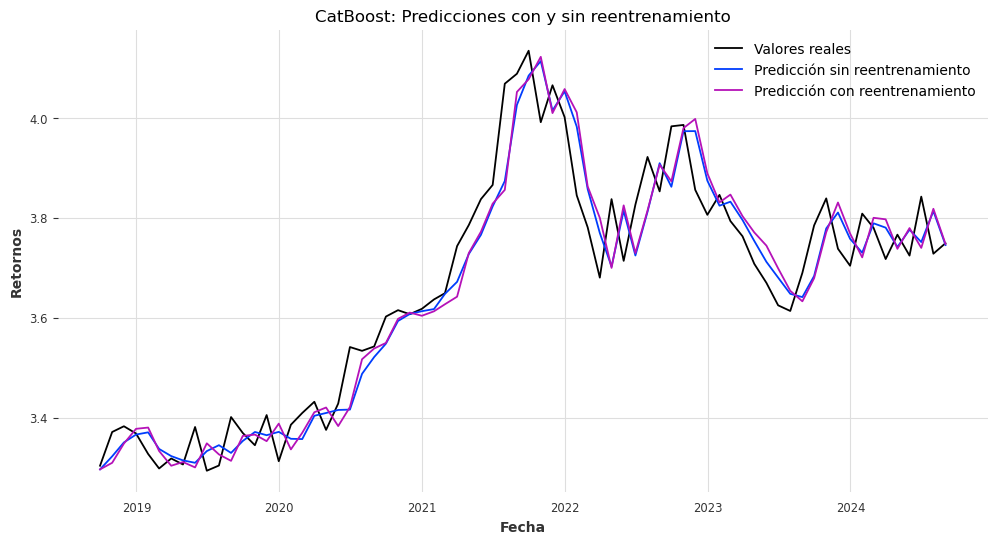

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
#plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(y_pred_with_retrain.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('CatBoost: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))
pred_returns_with_retrain = return_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

In [ ]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [ ]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

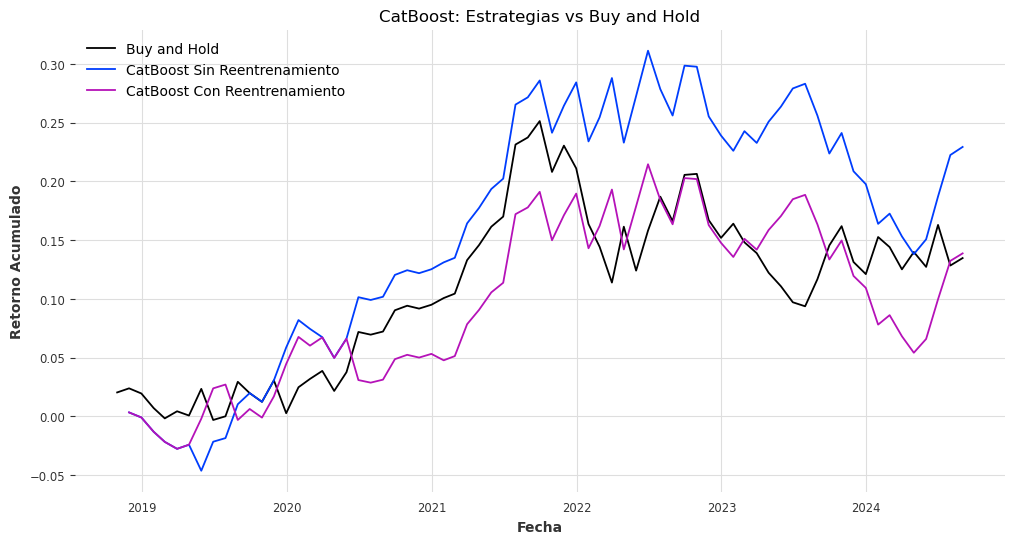

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
#plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='CatBoost Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='CatBoost Con Reentrenamiento')
plt.legend()
plt.title('CatBoost: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [ ]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia CATBOOST sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia CATBOOST con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia CATBOOST sin reentrenamiento:
Total Return: 0.2294
Annualized Return: 0.0355
Sharpe Ratio: 0.5513
Information Ratio: 0.0574
Max Drawdown: -0.1321
Hit Ratio: 59.1549

Estrategia CATBOOST con reentrenamiento:
Total Return: 0.1388
Annualized Return: 0.0222
Sharpe Ratio: 0.3572
Information Ratio: 0.0128
Max Drawdown: -0.1321
Hit Ratio: 57.7465


In [ ]:
# Convertir los valores reales y predicciones a TimeSeries de Darts
y_true_timeseries = TimeSeries.from_series(
    pd.Series(y_true, index=test.time_index))

y_pred_no_retrain_timeseries = TimeSeries.from_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))

y_pred_with_retrain_timeseries = TimeSeries.from_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

# Ahora podemos usar la función evaluate_model_performance sin modificarla
catboost_metrics_no_retrain, catboost_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "CATBOOST", retrain=False)

catboost_metrics_with_retrain, catboost_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "CATBOOST", retrain=True)

In [ ]:
# Convertir las predicciones de CatBoost a TimeSeries de Darts
catboost_forecast_no_retrain_unscaled = TimeSeries.from_series(
    pd.Series(y_pred_no_retrain, index=test.time_index))

catboost_forecast_with_retrain_unscaled = TimeSeries.from_series(
    pd.Series(y_pred_with_retrain, index=test.time_index))

# TIDEModel

In [ ]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_tide(train_data):
    def objective(trial):
        params = {
            'input_chunk_length': trial.suggest_int('input_chunk_length', 12, 72),
            'output_chunk_length': 1,
            'num_encoder_layers': trial.suggest_int('num_encoder_layers', 1, 4),
            'num_decoder_layers': trial.suggest_int('num_decoder_layers', 1, 4),
            'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128, 256]),
            'decoder_output_dim': trial.suggest_int('decoder_output_dim', 8, 32),
            'temporal_width_past': trial.suggest_int('temporal_width_past', 2, 8),
            'temporal_width_future': trial.suggest_int('temporal_width_future', 2, 8),
            'temporal_decoder_hidden': trial.suggest_int('temporal_decoder_hidden', 16, 64),
            'use_layer_norm': trial.suggest_categorical('use_layer_norm', [True, False]),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'n_epochs': 20,
            'random_state': 42
        }
        
        try:
            model = TiDEModel(**params)
            
            backtest = model.historical_forecasts(
                series=train_data,
                start=train_data.time_index[int(len(train_data) * 0.8)],
                forecast_horizon=3,
                stride=3,
                retrain=True,
                verbose=False,
                show_warnings=False
            )
            
            actual_values = train_data.slice_intersect(backtest).values()
            predicted_values = backtest.values()
            
            # Calculate metrics
            mae_error = mae(train_data.slice_intersect(backtest), backtest)
            direction_score, direction_string = calculate_directional_accuracy(actual_values, predicted_values, method='returns')
            
            # Normalize MAE
            mae_normalized = mae_error / 0.1
            
            # Combine metrics with more weight on direction
            combined_error = 0.4 * mae_normalized + 0.6 * (1 - direction_score)
            
            # Save metrics
            trial.set_user_attr('mae_original', float(mae_error))
            trial.set_user_attr('direction_accuracy', direction_string)
            trial.set_user_attr('combined_score', float(combined_error))
            
            return combined_error
            
        except Exception as e:
            print(f"Error in trial {trial.number}: {str(e)}")
            return float('inf')
    
    # Use TPESampler for better optimization
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    def print_callback(study, trial):
        if trial.number % 2 == 0:
            print(f"\nTrial {trial.number}:")
            print(f"MAE: {trial.user_attrs.get('mae_original', 'N/A'):.6f}")
            print(f"Direction Accuracy: {trial.user_attrs.get('direction_accuracy', 'N/A')}")
            print(f"Combined Score: {trial.user_attrs.get('combined_score', 'N/A'):.3f}")
            if trial.number > 0:
                print(f"Best so far: {study.best_value:.3f}")
    
    # Optimize with more trials for better results
    study.optimize(objective, n_trials=40, callbacks=[print_callback])
    
    # Prepare best parameters
    best_params = study.best_params
    best_params.update({
        'output_chunk_length': 1,
        'n_epochs': 100,
        'random_state': 42
    })
    
    # Print final metrics
    print("\nBest metrics found:")
    print(f"MAE: {study.best_trial.user_attrs['mae_original']:.6f}")
    print(f"Direction Accuracy: {study.best_trial.user_attrs['direction_accuracy']}")
    print(f"Combined Score: {study.best_value:.3f}")
    
    return best_params

In [ ]:
def train_tide(train_data):
    """
    Train TiDE model with optimized hyperparameters
    """
    loaded_params = load_hyperparameters('tide')
    if loaded_params is None:
        print("Optimizing hyperparameters for TiDE...")
        best_params = optimize_tide(train_data)
        save_hyperparameters(best_params, 'tide')
    else:
        print("Loading saved hyperparameters for TiDE...")
        best_params = loaded_params
    
    model = TiDEModel(**best_params)
    model.fit(train_data, verbose=False)
    save_model(model, 'tide')
    return model

In [ ]:
# Entrenar modelo TiDE
tide_model = train_tide(train_scaled)

Cargando hiperparámetros guardados para TiDE...


Modelo guardado en tide_model.pkl


In [ ]:
# Realizar rolling forecast
tide_forecast_no_retrain = step_by_step_forecast(tide_model, train_scaled, test_scaled, retrain=False, model_name='tide')

Cargando forecast guardado de tide_forecast_no_retrain.pkl


In [ ]:
tide_forecast_with_retrain = step_by_step_forecast(tide_model, train_scaled, test_scaled, retrain=True, model_name='tide')

Cargando forecast guardado de tide_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones

tide_forecast_no_retrain_unscaled = scaler.inverse_transform(tide_forecast_no_retrain)
tide_forecast_with_retrain_unscaled = scaler.inverse_transform(tide_forecast_with_retrain)

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = tide_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = tide_forecast_with_retrain_unscaled.values().flatten()

tide_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
tide_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

print("Evaluación del modelo TiDE sin reentrenamiento:")
for metric, value in tide_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo TiDE con reentrenamiento:")
for metric, value in tide_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo TiDE sin reentrenamiento:
MSE: 0.013365
RMSE: 0.115608
MAE: 0.090797
R2: 0.745703

Evaluación del modelo TiDE con reentrenamiento:
MSE: 0.009344
RMSE: 0.096666
MAE: 0.074782
R2: 0.822209


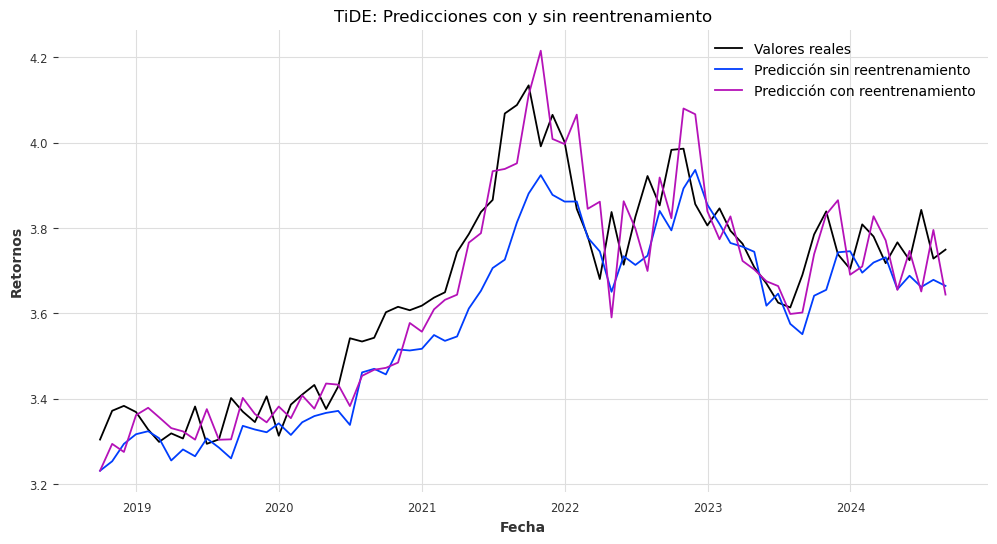

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index,y_true,label='Valores reales')
#plt.plot(test.time_index,y_pred_no_retrain,label='Predicción sin reentrenamiento')
plt.plot(tide_forecast_with_retrain_unscaled.time_index,y_pred_with_retrain,label='Predicción con reentrenamiento')
plt.legend()
plt.title('TiDE: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(tide_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(tide_forecast_with_retrain_unscaled.pd_series())

In [ ]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

In [ ]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

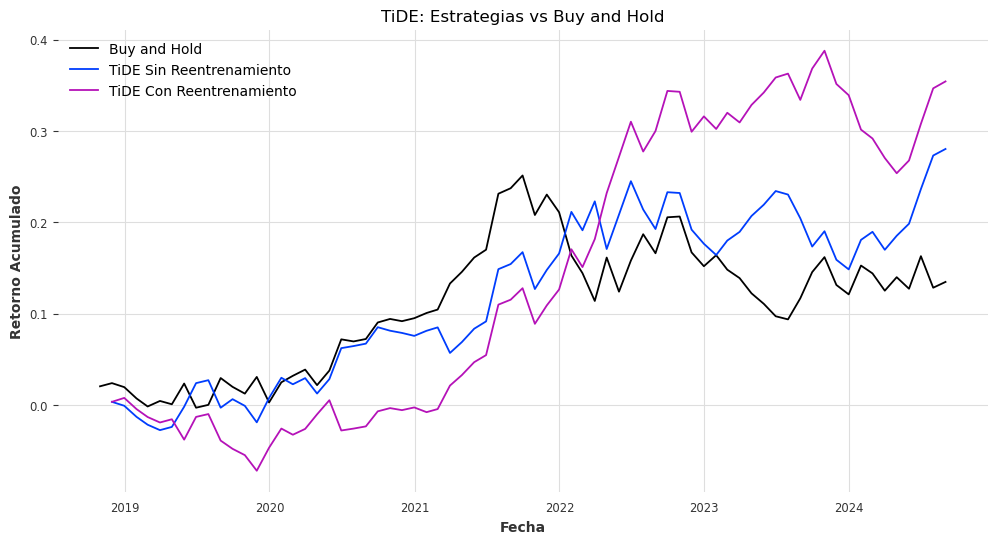

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, label='TiDE Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, label='TiDE Con Reentrenamiento')
plt.legend()
plt.title('TiDE: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

# PROPHET

In [ ]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[['PEN']])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
def optimize_prophet(train_data):
    def objective(trial):
        # Parámetros base de Prophet
        prophet_params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'growth': trial.suggest_categorical('growth', ['linear', 'flat'])
        }
        
        # Parámetros de estacionalidad
        seasonality_params = {
            'name': 'custom_seasonality',
            'seasonal_periods': trial.suggest_int('seasonal_periods', 3, 12),
            'fourier_order': trial.suggest_int('fourier_order', 3, 10)
        }
        
        # Crear modelo con los parámetros base y estacionalidad
        model = Prophet(
            add_seasonalities=[seasonality_params],  # Prophet espera una lista de diccionarios
            **prophet_params
        )
        
        # Validación cruzada
        train_length = int(len(train_data) * 0.8)
        train_subset = train_data[:train_length]
        val_subset = train_data[train_length:]
        
        future_covariates = datetime_attribute_timeseries(
            train_subset,
            attribute="month",
            cyclic=True,
            add_length=len(val_subset)
        )
        
        try:
            model.fit(train_subset, future_covariates=future_covariates)
            predictions = model.predict(len(val_subset), future_covariates=future_covariates)
            error = mae(val_subset, predictions)
        except Exception as e:
            print(f"Error durante la optimización: {str(e)}")
            error = float('inf')
        
        return error

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    return study.best_params

In [ ]:
def train_prophet(train_data):
    loaded_params = load_hyperparameters('prophet')
    if loaded_params is None:
        print("Optimizando hiperparámetros para Prophet...")
        best_params = optimize_prophet(train_data)
        save_hyperparameters(best_params, 'prophet')
    else:
        print("Cargando hiperparámetros guardados para Prophet...")
        best_params = loaded_params
    
    # Separar parámetros de Prophet y de estacionalidad
    seasonality_params = {
        'name': 'custom_seasonality',
        'seasonal_periods': best_params.pop('seasonal_periods'),
        'fourier_order': best_params.pop('fourier_order')
    }
    
    # Crear modelo con los parámetros optimizados
    model = Prophet(
        add_seasonalities=[seasonality_params],
        **best_params
    )
    
    future_covariates = datetime_attribute_timeseries(
        train_data,
        attribute="month",
        cyclic=True
    )
    
    print("Entrenando modelo Prophet...")
    model.fit(train_data, future_covariates=future_covariates)
    save_model(model, 'prophet')
    return model

In [ ]:
def prophet_step_by_step_forecast(model, train_data, test_data, retrain=False, progress_bar=None):
    forecast_filename = f'prophet_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    current_series = train_data.copy()
    actual_values = test_data.values()
    test_index = test_data.time_index
    
    freq = pd.infer_freq(test_index)
    if freq is None:
        freq = 'M'
    
    all_predictions = []
    
    for i in range(len(test_data)):
        # Generar covariables para la predicción
        future_covariates = datetime_attribute_timeseries(
            current_series,
            attribute="month",
            cyclic=True,
            add_length=1
        )
        
        # Realizar predicción
        pred = model.predict(n=1, future_covariates=future_covariates)
        
        # Almacenar la predicción
        all_predictions.append(pred.values()[0][0])
        
        # Actualizar la serie actual con el valor real
        new_point = TimeSeries.from_dataframe(
            pd.DataFrame({test_data.components[0]: [actual_values[i]]}, 
                       index=[test_index[i]]),
            freq=freq
        )
        current_series = current_series.append(new_point)
        
        # Reentrenar si es necesario
        if retrain:
            future_covariates = datetime_attribute_timeseries(
                current_series,
                attribute="month",
                cyclic=True
            )
            model.fit(current_series, future_covariates=future_covariates)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    # Convertir a arrays de numpy
    all_predictions = np.array(all_predictions).reshape(-1, 1)
    
    # Crear una única serie temporal con todas las predicciones
    forecast = TimeSeries.from_dataframe(
        pd.DataFrame(
            all_predictions,
            index=test_index,
            columns=['PEN']
        ),
        freq=freq
    )
    
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [ ]:
# Entrenar modelo Prophet
prophet_model = train_prophet(train_scaled)

23:31:06 - cmdstanpy - INFO - Chain [1] start processing


Cargando hiperparámetros guardados para Prophet...
Entrenando modelo Prophet...


23:31:06 - cmdstanpy - INFO - Chain [1] done processing


Modelo guardado en prophet_model.pkl


In [ ]:
# Realizar rolling forecast
prophet_forecast_no_retrain = prophet_step_by_step_forecast(
    prophet_model, train_scaled, test_scaled, retrain=False)

Cargando forecast guardado de prophet_forecast_no_retrain.pkl


In [ ]:
prophet_forecast_with_retrain = prophet_step_by_step_forecast(
    prophet_model, train_scaled, test_scaled, retrain=True)

Cargando forecast guardado de prophet_forecast_retrain.pkl


In [ ]:
# Desescalar las predicciones
prophet_forecast_no_retrain_unscaled = scaler.inverse_transform(prophet_forecast_no_retrain)
prophet_forecast_with_retrain_unscaled = scaler.inverse_transform(prophet_forecast_with_retrain)

In [ ]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = prophet_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = prophet_forecast_with_retrain_unscaled.values().flatten()

prophet_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
prophet_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

In [ ]:
print("Evaluación del modelo Prophet sin reentrenamiento:")
for metric, value in prophet_evaluation_no_retrain.items():
    print(f"{metric}: {value:.6f}")

print("\nEvaluación del modelo Prophet con reentrenamiento:")
for metric, value in prophet_evaluation_with_retrain.items():
    print(f"{metric}: {value:.6f}")

Evaluación del modelo Prophet sin reentrenamiento:
MSE: 0.260228
RMSE: 0.510126
MAE: 0.455709
R2: -3.951303

Evaluación del modelo Prophet con reentrenamiento:
MSE: 0.121610
RMSE: 0.348726
MAE: 0.299156
R2: -1.313838


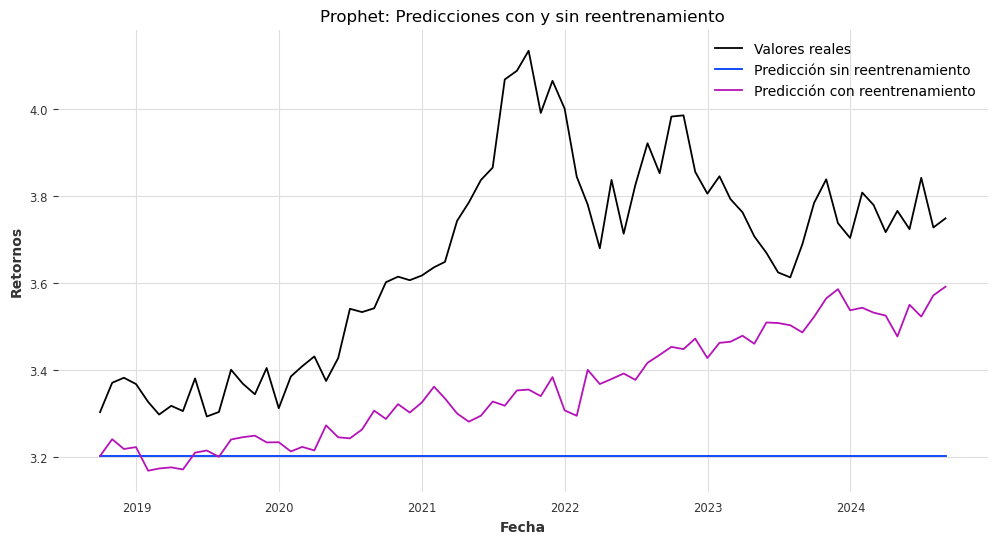

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label='Valores reales')
#plt.plot(test.time_index, y_pred_no_retrain, label='Predicción sin reentrenamiento')
plt.plot(test.time_index, y_pred_with_retrain, label='Predicción con reentrenamiento')
plt.legend()
plt.title('Prophet: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Retornos')
plt.show()

In [ ]:
# Implementar estrategia de trading y calcular métricas
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(prophet_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(prophet_forecast_with_retrain_unscaled.pd_series())

In [ ]:
# Calcular retornos de la estrategia
strategy_returns_no_retrain = implement_trading_strategy(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy(real_returns, pred_returns_with_retrain)

# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return(strategy_returns_with_retrain)

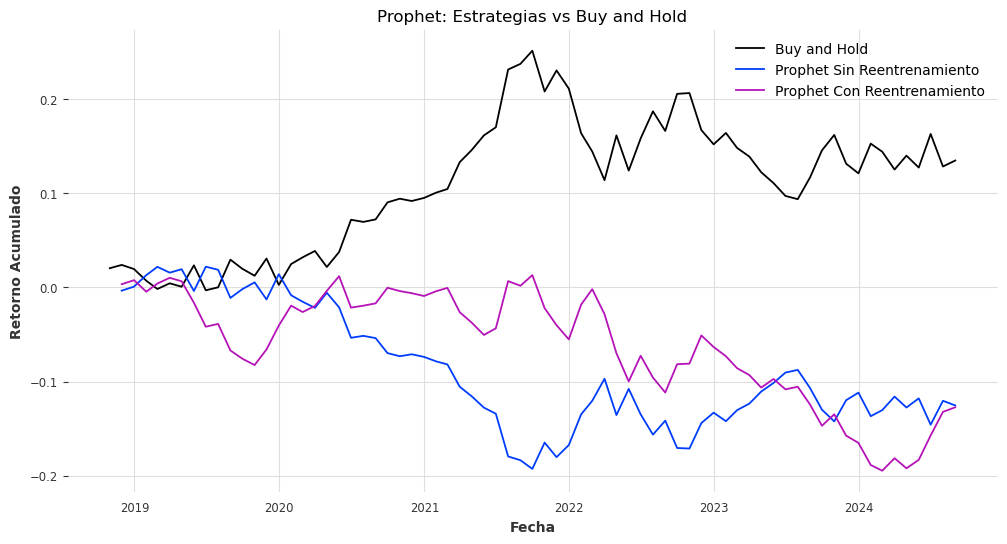

In [ ]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
# plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, 
#          label='Prophet Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, 
         label='Prophet Con Reentrenamiento')
plt.legend()
plt.title('Prophet: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.show()

In [ ]:
# Calcular métricas de rendimiento para ambas estrategias
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(strategy_returns_no_retrain,real_returns)
metrics_strategy_with_retrain = calculate_all_metrics(strategy_returns_with_retrain,real_returns)

In [ ]:
print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia Prophet sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia Prophet con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia Prophet sin reentrenamiento:
Total Return: -0.1253
Annualized Return: -0.0224
Sharpe Ratio: -0.2976
Information Ratio: -0.0859
Max Drawdown: -0.2101
Hit Ratio: 0.0000

Estrategia Prophet con reentrenamiento:
Total Return: -0.1273
Annualized Return: -0.0227
Sharpe Ratio: -0.3033
Information Ratio: -0.1230
Max Drawdown: -0.2050
Hit Ratio: 54.9296


In [ ]:
# Calcular métricas finales
prophet_metrics_no_retrain, prophet_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "PROPHET", retrain=False)
prophet_metrics_with_retrain, prophet_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "PROPHET", retrain=True)